# ResBaz: Building a Neural Network

## Exercise 2: Simple Classification example (20 minutes)

It is time to become particle physicists! At the Large Hadron Collider (LHC) protons are sped up to near the speed of light, to then be smashed into each other, creating similar conditions to our early universe. From these collisions we shower of particles that go through detectors such as the LHCb, or ATLAS, to find rare particles and interactions. The detector I take data from is the LHCb experiment, specialised at looking into heavy particles which contain b and c quarks.

https://www.youtube.com/watch?v=-LljS3Zn3rQ


Detectors like the LHCb are quite remarkable in there ability to detect rare particles which can not be seen in our daily life. In this example we are looking for a $\Lambda_{c}^{+}$ baryon which decays into a proton, a Kaon, and a pion. The detectors are good at piecing together these tracks, but often we get tracks which look like the come from the same place but just happen to look this way. The detector will think this is a true $\Lambda_{c}^{+}$ baryon and this will be recorded, this source of background is known as combinatorial background, and it often hides our true signal peak. But have no fear, classifiers are here! Like other datasets, the $\Lambda_{c}^{+}$ candidates we collect have features. 

In [101]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit
import torch

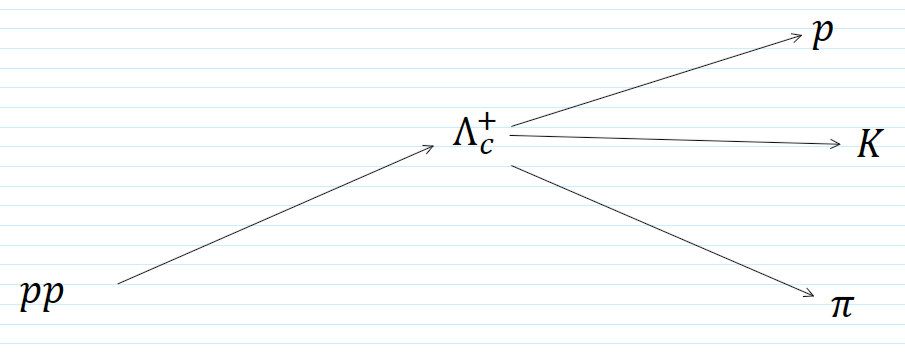

In [6]:
from IPython.display import Image
image_path = "Lc_decay.png"
Image(filename=image_path)

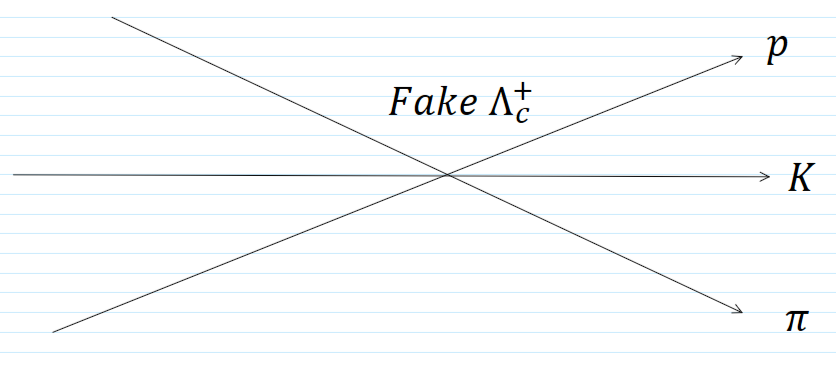

In [7]:
image_path = "Lc_comb.png"
Image(filename=image_path)

Although it would be cool to work with real data it is a bit inconvenient memory-wise to do so. So I generate some mock data. 

In [132]:
def make_data():
    xr = (2200, 2400)
    rng = np.random.default_rng()  # Random number generator for reproducibility

    # Number of signal and background samples
    num_signal = 1000
    num_background = rng.integers(40000, 50000)  # Add randomness to background size

    # Signal mass
    sig_data_mass = np.random.normal(loc=2.2875e3, scale=4.35, size=num_signal)
    sig_data_mass = sig_data_mass[(xr[0] < sig_data_mass) & (xr[1] > sig_data_mass)]

    # Background mass
    bkg_data_mass = np.random.exponential(scale=200, size=num_background) + 2.20e3
    bkg_data_mass = bkg_data_mass[(xr[0] < bkg_data_mass) & (xr[1] > bkg_data_mass)]

    # Combine mass data
    data_mass = np.append(sig_data_mass, bkg_data_mass)

    # IP distribution
    xr = (0, 10)
    bkg_data_IP = np.random.normal(1, 1, num_background)  # Gaussian for background
    bkg_data_IP = bkg_data_IP[(xr[0] < bkg_data_IP) & (xr[1] > bkg_data_IP)]
    sig_data_IP = np.random.exponential(scale=0.1, size=num_signal)  # Exponential for signal
    sig_data_IP = sig_data_IP[(xr[0] < sig_data_IP) & (xr[1] > sig_data_IP)]

    IP_data = np.append(sig_data_IP, bkg_data_IP)

    # PT distribution
    xr = (0, 60000)
    sig_data_PT = np.random.normal(6000, 1000, num_signal)  # Gaussian for signal
    sig_data_PT = sig_data_PT[(xr[0] < sig_data_PT) & (xr[1] > sig_data_PT)]
    bkg_data_PT = np.random.normal(5000, 1000, num_background)  # Gaussian for background
    bkg_data_PT = bkg_data_PT[(xr[0] < bkg_data_PT) & (xr[1] > bkg_data_PT)]

    PT_data = np.append(sig_data_PT, bkg_data_PT)

    # Combine data into arrays
    sig_arr = np.hstack([
        np.array(sig_data_mass).reshape(-1, 1),
        np.array(sig_data_IP).reshape(-1, 1),
        np.array(sig_data_PT).reshape(-1, 1)
    ])

    bkg_arr = np.hstack([
        np.array(bkg_data_mass).reshape(-1, 1),
        np.array(bkg_data_IP[:len(bkg_data_mass)]).reshape(-1, 1),
        np.array(bkg_data_PT[:len(bkg_data_mass)]).reshape(-1, 1)
    ])

    # Create DataFrames
    sig_df = pd.DataFrame(sig_arr, columns=["Lc_M", "Lc_IP", "Lc_PT"])
    sig_df['class'] = 1

    bkg_df = pd.DataFrame(bkg_arr, columns=["Lc_M", "Lc_IP", "Lc_PT"])
    bkg_df['class'] = 0

    # Concatenate signal and background data
    data_df = pd.concat([sig_df, bkg_df], axis=0, ignore_index=True)

    return data_df

data_df = make_data()


The problem we have is that our mass peak is covered by a blanket of combinatorial background, where we should see a signal mass peak we see background.

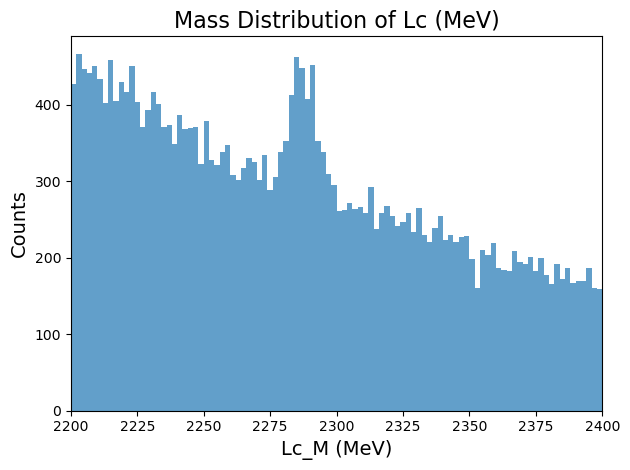

In [133]:
import matplotlib.pyplot as plt

# Create the histogram
plt.hist(data_df['Lc_M'], bins=100, alpha=0.7)

# Add title and labels
plt.title('Mass Distribution of Lc (MeV)', fontsize=16)
plt.xlabel('Lc_M (MeV)', fontsize=14)
plt.ylabel('Counts', fontsize=14)

# Optionally, set limits if needed to focus the plot range
plt.xlim(2200, 2400)  # You can adjust this based on your data range

# Show the plot
plt.tight_layout()
plt.show()


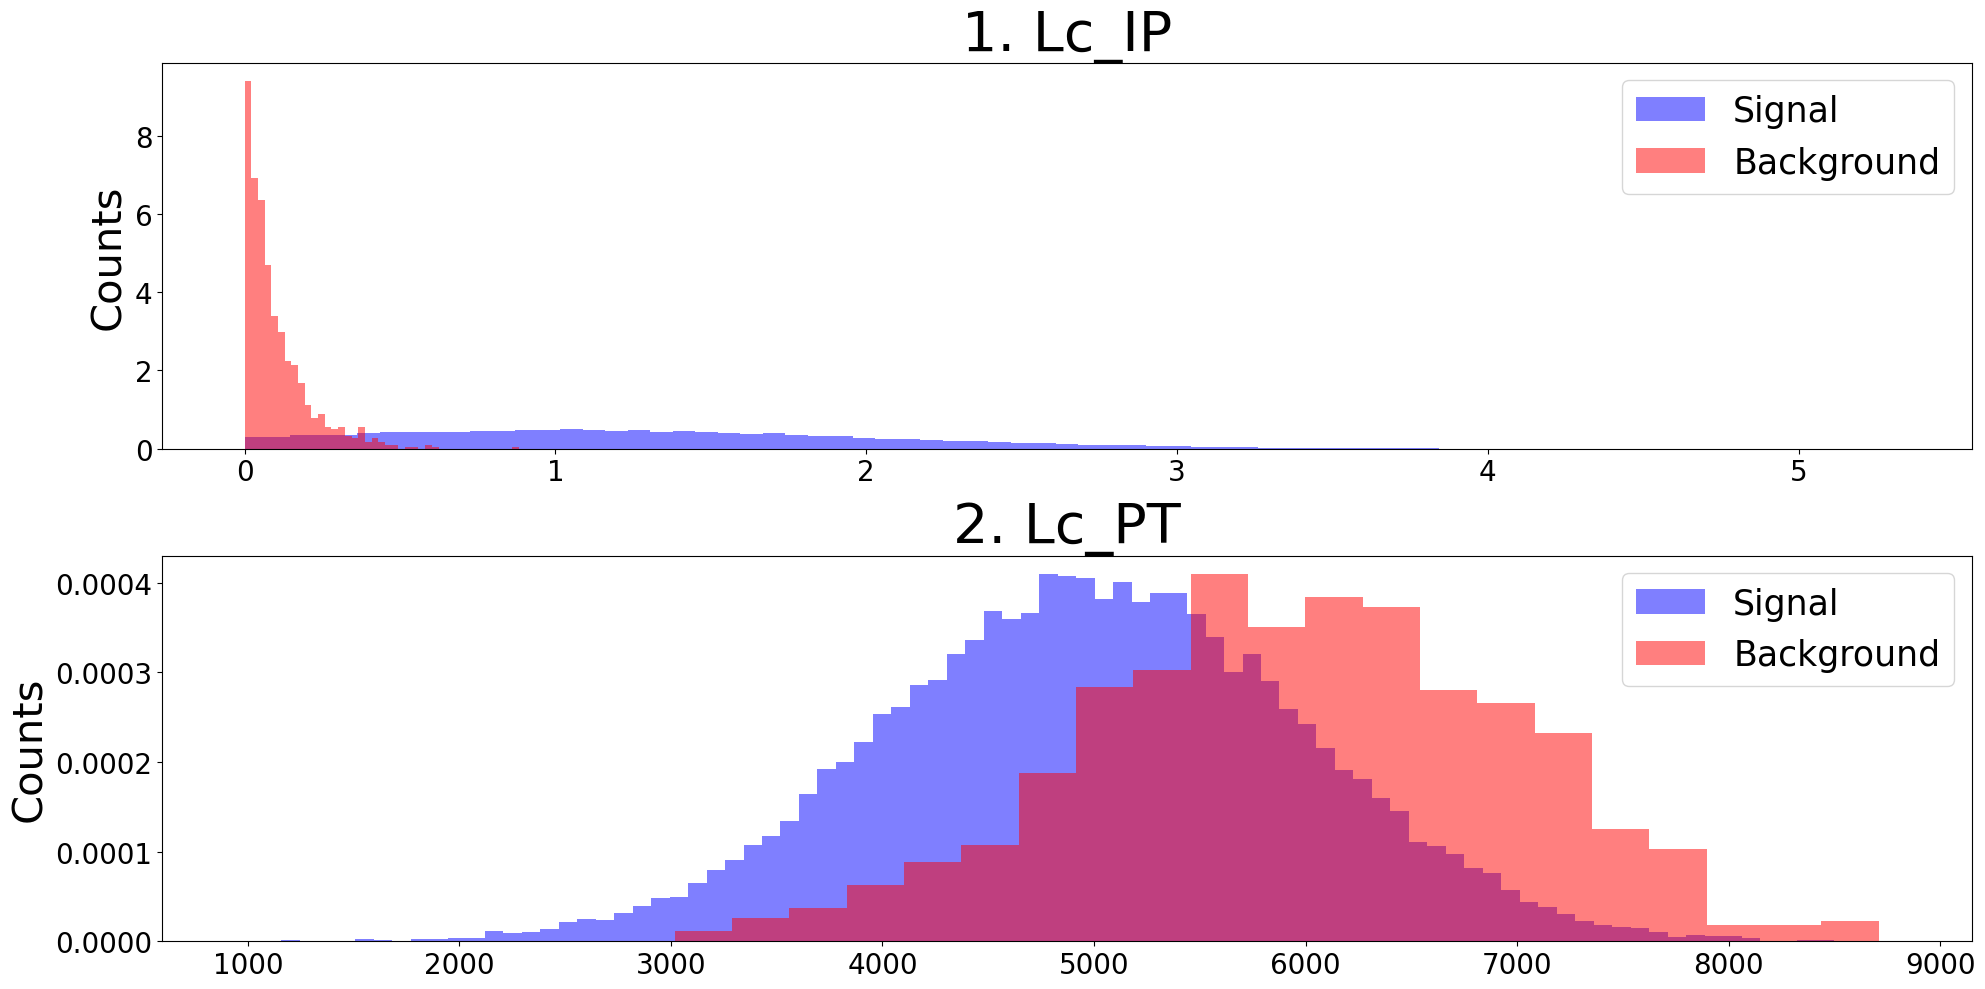

In [134]:
# Plot histograms for each training variable, comparing Signal TOS and exTIS categories:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 5 * 2))
for i, feature in enumerate(['Lc_IP', 'Lc_PT']):
    # Plot histogram for the filtered Signal TOS data:
    axes[i].hist(data_df[data_df['class'] == 0][feature], bins='fd', color='blue', alpha=0.5, label='Signal', density=True)
    # Plot histogram for the filtered Signal exTIS data:
    axes[i].hist(data_df[data_df['class'] == 1][feature], bins='fd', color='red', alpha=0.5, label='Background', density=True)
    # Add enumeration to the title
    axes[i].set_title(f'{i+1}. {feature}', fontsize=40)
    axes[i].set_ylabel('Counts', fontsize=30)
    axes[i].legend(fontsize=25)
    axes[i].tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.show()


We can split the data a different way into a train and test split

In [135]:
# Another way to split the data:

nfolds = 4  # Define number of folds

def add_folds(df, nfolds=nfolds): 
    df['folds'] = df.index % nfolds  # Assign folds based on index
    return df

add_folds(data_df)

,Lc_M,Lc_IP,Lc_PT,class,folds
0,2290.921129,0.033436,5219.371964,1,0
1,2291.524337,0.091775,4386.570825,1,1
2,2280.907603,0.017323,6224.358757,1,2
3,2284.718722,0.112334,5372.725698,1,3
4,2297.657055,0.015545,5018.124315,1,0
...,...,...,...,...,...
29653,2267.322082,1.486569,6502.749965,0,1
29654,2251.370392,1.215850,3740.288536,0,2
29655,2345.634616,3.032476,6945.720138,0,3
29656,2280.157284,0.954287,3705.554532,0,0


In [136]:
X_train = data_df[data_df['folds'] != 0][['Lc_IP', 'Lc_PT']]
X_test = data_df[data_df['folds'] == 0][['Lc_IP', 'Lc_PT']]
Y_train = data_df[data_df['folds'] != 0]['class']
Y_test = data_df[data_df['folds'] == 0]['class']

Scale the data:

In [137]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0, ddof=1)
x = (X_train - X_mean) / X_std
x = x.to_numpy()
y = Y_train.to_numpy().reshape(-1,1)
x_test = (X_test - X_mean) / X_std
x_test = x_test.to_numpy()
y_test = Y_test.to_numpy().reshape(-1,1)

In [138]:
# Let's define some variables for the number of inputs and outputs.
N, D_in = x.shape
N, D_out = y.shape
H = 7 # The number of neurons in the hidden layer.

**Exercise**
* Try to use our previous PyTorch code from Ex1, instead of our loss function we used before use instead torch.nn.BCELoss(reduction='sum') which is more suited for classification.

In [139]:
# Initialise:...

# Let's define some variables for the number of inputs and outputs.
N, D_in = x.shape
N, D_out = y.shape
H = 7 # The number of neurons in the hidden layer.

x_torch = torch.tensor(x, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)

# Construct the model.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Sigmoid(),
    torch.nn.Linear(H, D_out),
    torch.nn.Sigmoid(),
)

loss_fn = torch.nn.BCELoss(reduction='sum')

epochs = 20000
learning_rate = 1e-4

losses = np.empty(epochs)
losses2 = np.empty(epochs)


for t in range(epochs):
    # Forward pass.
    y_pred_torch = model(x_torch)
    
    # Compute loss.
    loss = loss_fn(y_pred_torch, y_torch)
    if t % 100 == 99:
        print(t, loss.item())
    losses[t] = loss.item()

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass.
    loss.backward()

    # Update the weights
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
            
#     Run the forward pass on the test data:

    x_test_torch = torch.tensor(x_test, dtype=torch.float32)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32)

    y_pred_test_torch = model(x_test_torch)
    # Compute loss.
    loss = loss_fn(y_pred_test_torch, y_test_torch)
    if t % 100 == 99:
        print(t, loss.item())
    losses2[t]=loss.item()
    
    

99 2046.02880859375
99 679.4295654296875
199 1756.6298828125
199 584.9593505859375
299 1607.6318359375
299 536.7942504882812
399 1523.88623046875
399 510.10089111328125
499 1474.116455078125
499 494.5211181640625
599 1442.85595703125
599 484.9471130371094
699 1422.345703125
699 478.8285217285156
799 1408.446533203125
799 474.8103332519531
899 1398.79736328125
899 472.1231994628906
999 1391.9737548828125
999 470.30511474609375
1099 1387.0751953125
1099 469.06597900390625
1199 1383.5123291015625
1199 468.21795654296875
1299 1380.888427734375
1299 467.6364440917969
1399 1378.931396484375
1399 467.2374572753906
1499 1377.4521484375
1499 466.9640197753906
1599 1376.31787109375
1599 466.77685546875
1699 1375.4342041015625
1699 466.64898681640625
1799 1374.7340087890625
1799 466.56195068359375
1899 1374.168701171875
1899 466.5025634765625
1999 1373.703857421875
1999 466.46221923828125
2099 1373.3140869140625
2099 466.4344787597656
2199 1372.9814453125
2199 466.4154357910156
2299 1372.69287109

17899 1368.5015869140625
17899 466.7705078125
17999 1368.4996337890625
17999 466.7708740234375
18099 1368.497802734375
18099 466.771240234375
18199 1368.49560546875
18199 466.7715148925781
18299 1368.49365234375
18299 466.7716979980469
18399 1368.491455078125
18399 466.7718200683594
18499 1368.489501953125
18499 466.77191162109375
18599 1368.4873046875
18599 466.77197265625
18699 1368.485107421875
18699 466.7718505859375
18799 1368.4830322265625
18799 466.771728515625
18899 1368.480712890625
18899 466.7715148925781
18999 1368.478271484375
18999 466.7712097167969
19099 1368.475830078125
19099 466.77081298828125
19199 1368.473388671875
19199 466.7703552246094
19299 1368.4710693359375
19299 466.7698059082031
19399 1368.4683837890625
19399 466.76910400390625
19499 1368.4656982421875
19499 466.76837158203125
19599 1368.462890625
19599 466.7674560546875
19699 1368.4603271484375
19699 466.7664489746094
19799 1368.45703125
19799 466.7652893066406
19899 1368.4542236328125
19899 466.764007568359

Losses recorded by loss function:

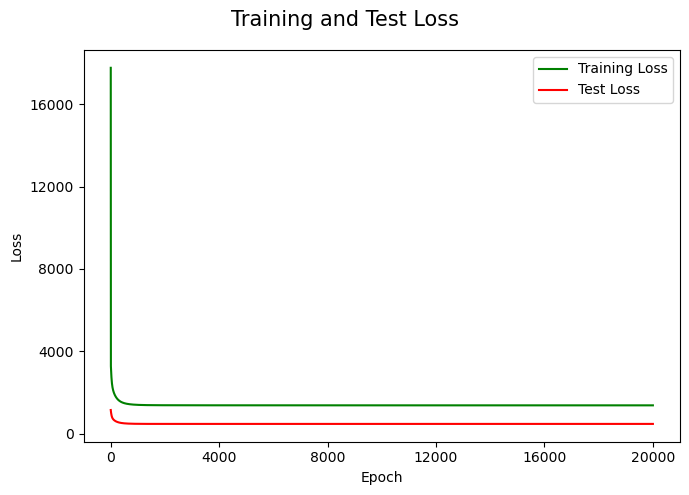

In [140]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(figsize=(7,5))
fig.suptitle('Training and Test Loss',fontsize = 15)

ax.plot(losses, color = "green", label = "Training Loss")

ax.plot(losses2, color = "red", label = "Test Loss")

plt.legend()

ax.set_xlabel("Epoch", fontsize = 10)
ax.set_ylabel("Loss", fontsize = 10)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(6))
fig.tight_layout()

Look at our validation set to see how the NN model cleans our mass peak

In [144]:
Y_pred = y_pred_test_torch.detach().numpy()
data_df.loc[data_df['folds'] == 0, 'pred'] = Y_pred

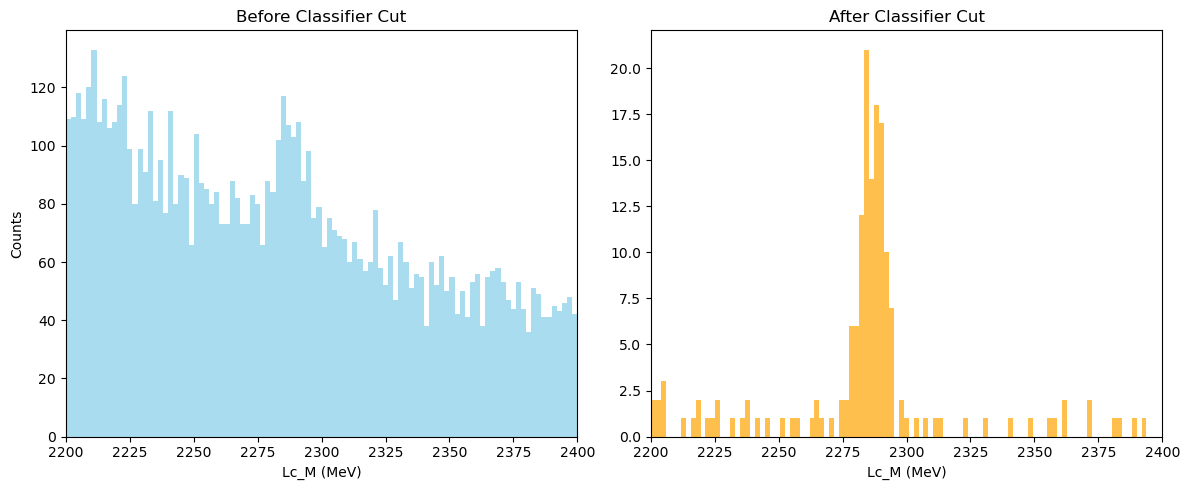

In [145]:
import matplotlib.pyplot as plt

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define the x-axis range
x_range = (2200, 2400)

# Before classifier cut
axes[0].hist(data_df[data_df['folds'] == 0]['Lc_M'], bins=100, color='skyblue', alpha=0.7)
axes[0].set_title('Before Classifier Cut')
axes[0].set_xlabel('Lc_M (MeV)')
axes[0].set_ylabel('Counts')
axes[0].set_xlim(x_range)  # Set x-axis range

# After classifier cut
axes[1].hist(data_df[(data_df['folds'] == 0) & (data_df['pred'] > 0.5)]['Lc_M'], bins=100, color='orange', alpha=0.7)
axes[1].set_title('After Classifier Cut')
axes[1].set_xlabel('Lc_M (MeV)')
axes[1].set_xlim(x_range)  # Set x-axis range

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Can also think about some metric to judge how go your classification went: ROC (Reciever Operating Characteristics) curve and AUC score

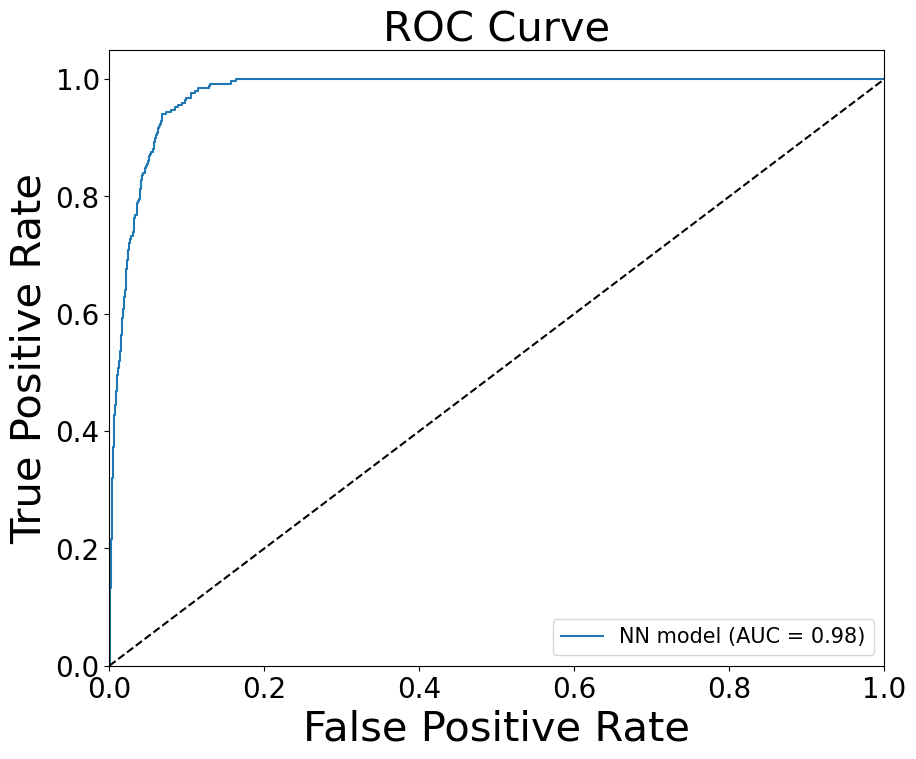

In [146]:
# Calculate predictions:
plt.figure(figsize=(10, 8))

# Compute ROC curve and AUC

fpr, tpr, threshold = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'NN model (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=30)
plt.ylabel('True Positive Rate', fontsize=30)
plt.title(f'ROC Curve', fontsize=30)

plt.legend(loc="lower right", fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()